<a href="https://colab.research.google.com/github/swagata87/IITKanpurPhy654/blob/main/jetImage_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p data
!wget -O data/jet_images.h5 "https://zenodo.org/record/3901869/files/jet_images.h5?download=1"

--2024-07-13 05:04:15--  https://zenodo.org/record/3901869/files/jet_images.h5?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3901869/files/jet_images.h5 [following]
--2024-07-13 05:04:15--  https://zenodo.org/records/3901869/files/jet_images.h5
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 85520350 (82M) [application/octet-stream]
Saving to: ‘data/jet_images.h5’

data/jet_images.h5  100%[===================>]  81.56M  19.1MB/s    in 4.3s    

2024-07-13 05:04:20 (19.1 MB/s) - ‘data/jet_images.h5’ saved [85520350/85520350]



In [23]:
import h5py

h5f = h5py.File("data/jet_images.h5", "r")

for key in h5f.keys():
    print(key) #Names of the root level object names in HDF5 file.
    print(type(h5f[key])) # get the object type: usually group or dataset



QCD
<class 'h5py._hl.dataset.Dataset'>
QCD_particles
<class 'h5py._hl.dataset.Dataset'>
TT
<class 'h5py._hl.dataset.Dataset'>
TT_particles
<class 'h5py._hl.dataset.Dataset'>


In [24]:
jet_images_dict = {}
jet_images_dict["QCD"] = h5f["QCD"][()]
jet_images_dict["TT"] = h5f["TT"][()]

h5f.close()

In [3]:
# 4D tensor (tensorflow backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb values, etc.)
print(jet_images_dict["QCD"].shape)
print(jet_images_dict["TT"].shape)

(3305, 30, 30, 1)
(1722, 30, 30, 1)


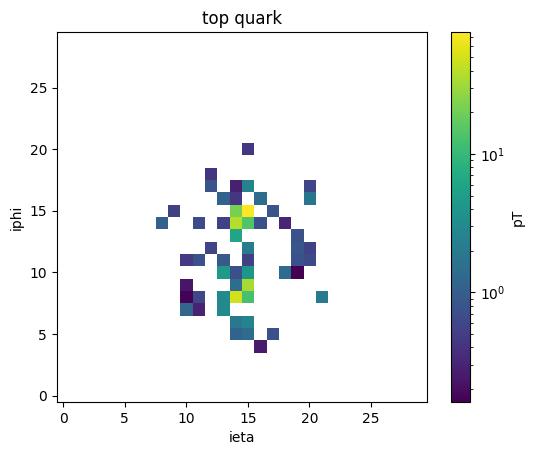

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

%matplotlib inline

# plot ttbar jet
i = 10
plt.figure()
plt.imshow(
    jet_images_dict["TT"][i, :, :, 0].T,
    norm=mpl.colors.LogNorm(),
    origin="lower",
    interpolation="none",
)
cbar = plt.colorbar()
cbar.set_label("pT")
plt.xlabel("ieta")
plt.ylabel("iphi")
plt.title('top quark')
plt.show()

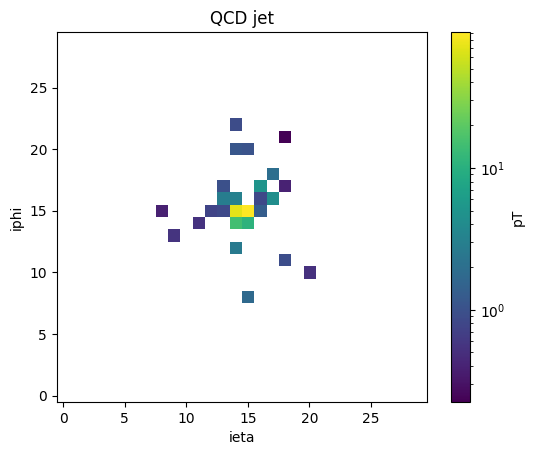

In [21]:
# plot QCD jet
i = 15
plt.figure()
plt.imshow(
    jet_images_dict["QCD"][i, :, :, 0].T,
    norm=mpl.colors.LogNorm(),
    origin="lower",
    interpolation="none",
)
cbar = plt.colorbar()
cbar.set_label("pT")
plt.xlabel("ieta")
plt.ylabel("iphi")
plt.title('QCD jet')
plt.show()

In [8]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    Dense,
    BatchNormalization,
    Concatenate,
)
from tensorflow.keras.regularizers import l1, l2

nx = 30
ny = 30
inputs = Input(shape=(nx, ny, 1), name="input")
x = Conv2D(
    filters=8,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    activation="relu",
    name="conv2d_1",
    kernel_regularizer=l2(0.01),
)(inputs)
x = BatchNormalization(momentum=0.6, name="batchnorm_1")(x)
x = MaxPool2D(pool_size=(2, 2), name="maxpool2d_1")(x)
x = Flatten(name="flatten")(x)
x = Dense(64, activation="relu", name="dense")(x)
outputs = Dense(1, activation="sigmoid", name="output")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 30, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 8)         80        
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 30, 30, 8)         32        
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 15, 15, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1800)              0         
                                                                 
 dense (Dense)               (None, 64)                115264    
                                                             

In [11]:
jet_images = np.concatenate([jet_images_dict["TT"], jet_images_dict["QCD"]])
jet_labels = np.concatenate(
    [np.ones(len(jet_images_dict["TT"])), np.zeros(len(jet_images_dict["QCD"]))]
)

X = jet_images
Y = jet_labels

from sklearn.model_selection import train_test_split

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

print("number of ttbar jets for training/validation: %i" % np.sum(Y_train_val == 1))
print("number of QCD jets for training/validation: %i" % np.sum(Y_train_val == 0))

print("number of ttbar jets for testing: %i" % np.sum(Y_test == 1))
print("number of QCD jets for testing: %i" % np.sum(Y_test == 0))

# early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into conv2d_model.h5
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    "conv2d_model.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)

number of ttbar jets for training/validation: 1384
number of QCD jets for training/validation: 2637
number of ttbar jets for testing: 338
number of QCD jets for testing: 668


In [12]:
# Train classifier
history = model.fit(
    X_train_val,
    Y_train_val,
    epochs=100,
    batch_size=1024,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint],
    validation_split=0.25,
)

Epoch 1/100
3/3 [==============================] - 3s 609ms/step - loss: 1.1514 - accuracy: 0.5022 - val_loss: 0.5665 - val_accuracy: 0.7247
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 432ms/step - loss: 0.5047 - accuracy: 0.7552 - val_loss: 0.4341 - val_accuracy: 0.8191
Epoch 3/100
3/3 [==============================] - 1s 454ms/step - loss: 0.3760 - accuracy: 0.8554 - val_loss: 0.4196 - val_accuracy: 0.8748
Epoch 4/100
3/3 [==============================] - 1s 414ms/step - loss: 0.3781 - accuracy: 0.8819 - val_loss: 0.4217 - val_accuracy: 0.8827
Epoch 5/100
3/3 [==============================] - 1s 465ms/step - loss: 0.3465 - accuracy: 0.8925 - val_loss: 0.3869 - val_accuracy: 0.8797
Epoch 6/100
3/3 [==============================] - 1s 425ms/step - loss: 0.3252 - accuracy: 0.8886 - val_loss: 0.3906 - val_accuracy: 0.8728
Epoch 7/100
3/3 [==============================] - 1s 440ms/step - loss: 0.3269 - accuracy: 0.8833 - val_loss: 0.3786 - val_accuracy: 0.8777
Epoch 8/100
3/3 [==============================] - 2s 818ms/step - loss: 0.3122 - accuracy: 0.8959 - val_loss: 0.3669 - val_accuracy: 0.8877
Epoch 9/100
3/3 [========

32/32 [==============================] - 0s 7ms/step


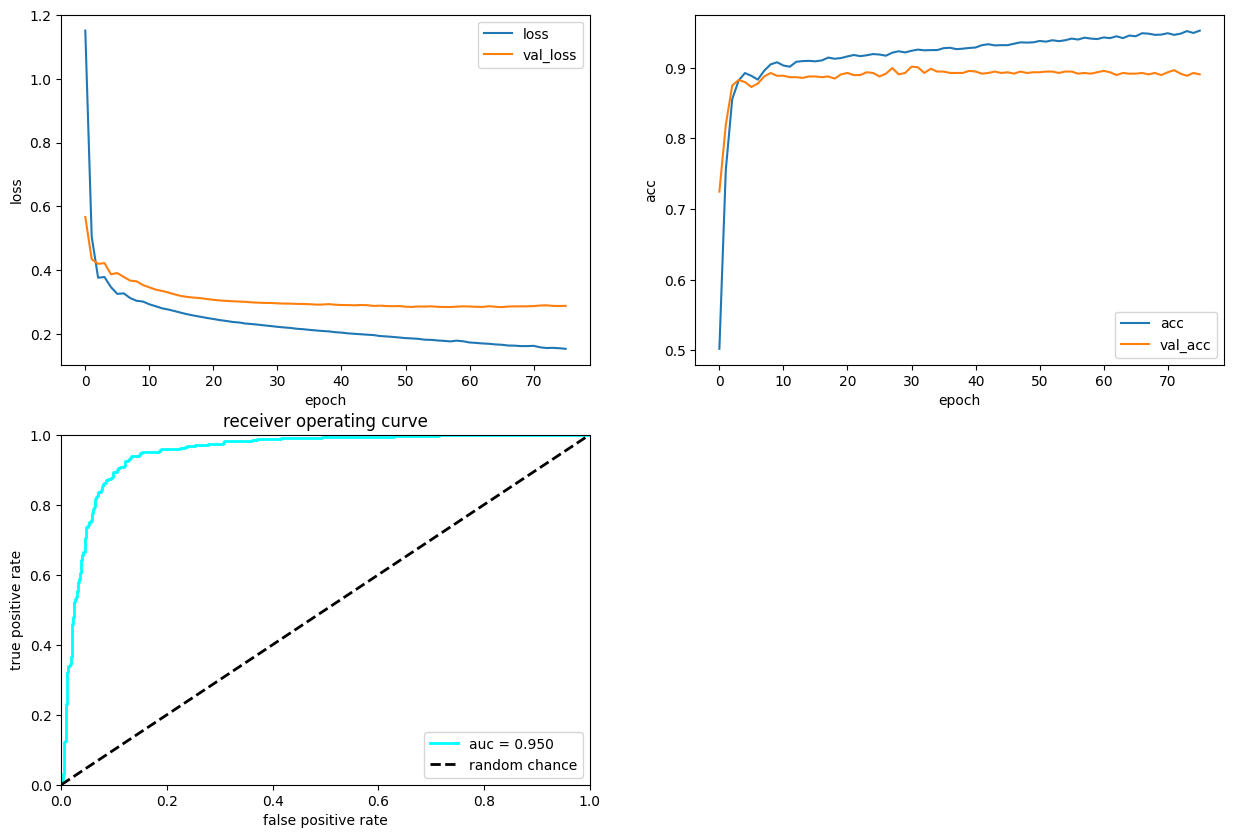

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="val_loss")
ax.legend(loc="upper right")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history["accuracy"], label="acc")
ax.plot(history.history["val_accuracy"], label="val_acc")
ax.legend(loc="lower right")
ax.set_xlabel("epoch")
ax.set_ylabel("acc")

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")
ax.set_title("receiver operating curve")
ax.legend(loc="lower right")
plt.show()